

---



---
## Task 1(a) - 1(c)

We will use transfer learnign for a task of classifying Flowers and Bees.
Bees vs Ants Classification Using Transfer Learning

This project addresses the binary classification problem of identifying whether an image contains a bee or an ant. The goal is to use transfer learning with pre-trained convolutional neural networks (CNNs) to efficiently classify images with limited data.
---



---




## ( All the conclusions and inferences are for the current run, if the code is run again it might change its results )

### Code inspired from

https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#convnet-as-fixed-feature-extractor




## Importing all packages and datasets that are needed.

In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
# This is to import the dataset of bees vs ants
import zipfile

In [ ]:
cd

/root


In [ ]:
# Since we are supposed to store the file after unzipping the dateset in the current directory
# The above cell gave us the current directory: /root
# And the directory inside root, has to be named data  
!mkdir data
!wget --no-check-certificate \
    "https://download.pytorch.org/tutorial/hymenoptera_data.zip" \
    -O "/root/data/hymenoptera_data.zip"
    
#W need to open the zip file in read mode.
zipfile_read = zipfile.ZipFile('/root/data/hymenoptera_data.zip', 'r')

#Extracting the files.
zipfile_read.extractall('/root/data')
zipfile_read.close()

--2022-05-05 22:47:45--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.65.229.105, 18.65.229.70, 18.65.229.14, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.65.229.105|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘/root/data/hymenoptera_data.zip’

/root/data/hymenopt 100%[===================>]  45.10M  80.2MB/s    in 0.6s    

2022-05-05 22:47:46 (80.2 MB/s) - ‘/root/data/hymenoptera_data.zip’ saved [47286322/47286322]



We need to keep the dataset in the current directory for the next section.

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Visualizing the data.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


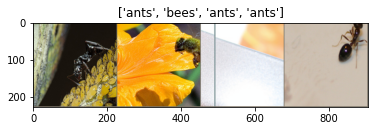

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training Module 

Training the model.

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
# -------------------------------------------------------------------------------------------------------------------    
# Here I made edits for task 1(c)
    # Here declare the lists that will store the validation loss and accuracy in order to plot it for each epoch
    val_loss = [] # For plotting the validation loss plot
    acc = []      # For plotting the accuracy plot 
    ep = []       # Just storing the epoch number
# -------------------------------------------------------------------------------------------------------------------

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

# -------------------------------------------------------------------------------------------------------------------    
# Here I made edits for task 1(c)
            # if - validation cycle, loss and acc append with epoch values
            if phase == 'val':
              val_loss.append(epoch_loss) # appending the validation loss of every epoch
              acc.append(epoch_acc)       # appending the accuracy of every epoch 
              ep.append(epoch)            # storing the epoch number
# -------------------------------------------------------------------------------------------------------------------
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')


# -------------------------------------------------------------------------------------------------------------------    
# Here I made edits for task 1(c)
    # Plottings of Validation loss and accuracy for every epoch
    
    # Plotting Validation Loss
    plt.plot(ep, val_loss)
    plt.xlabel('Epochs')
    plt.ylabel('Validation Loss')
    plt.title('Variation of validation Loss vs epochs')
    plt.show()
    print()

    # Plotting Accuracy
    plt.plot(ep, acc)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Variation of Accuracy vs epochs')
    plt.show()
    print()
# -------------------------------------------------------------------------------------------------------------------

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions.

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Training the ConvNet as a fine-tuned feature extractor (gradients on)

Finetuning the ConvNet

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Train and evaluate.

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.5529 Acc: 0.7049
val Loss: 0.2712 Acc: 0.9150

Epoch 1/24
----------
train Loss: 0.5637 Acc: 0.7992
val Loss: 0.3033 Acc: 0.9085

Epoch 2/24
----------
train Loss: 0.5530 Acc: 0.7828
val Loss: 0.4887 Acc: 0.8497

Epoch 3/24
----------
train Loss: 0.5479 Acc: 0.7746
val Loss: 0.3116 Acc: 0.8889

Epoch 4/24
----------
train Loss: 0.5704 Acc: 0.8033
val Loss: 0.5578 Acc: 0.7451

Epoch 5/24
----------
train Loss: 0.5631 Acc: 0.7582
val Loss: 0.2679 Acc: 0.9085

Epoch 6/24
----------
train Loss: 0.5098 Acc: 0.7992
val Loss: 0.2865 Acc: 0.9150

Epoch 7/24
----------
train Loss: 0.4930 Acc: 0.8156
val Loss: 0.2487 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.4210 Acc: 0.8074
val Loss: 0.2659 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.3199 Acc: 0.8852
val Loss: 0.2439 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.2531 Acc: 0.9016
val Loss: 0.2343 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.2545 Acc: 0.8811
val Loss: 0.2623 Acc: 0.9020

Epoch 12/24
----------
t

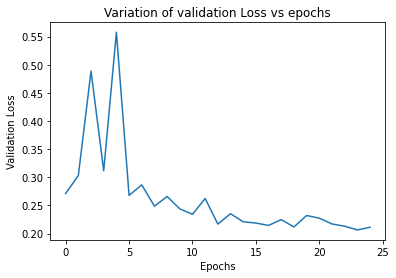

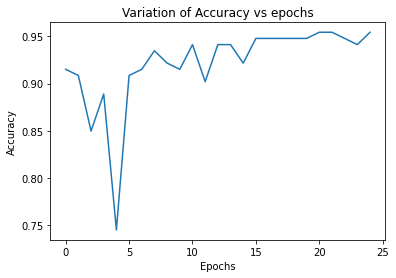

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Visualize model fit.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


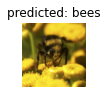

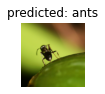

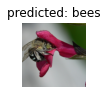

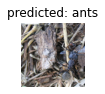

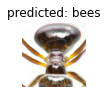

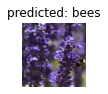

In [ ]:
visualize_model(model_ft)

# Training the ConvNet as a fixed feature extractor (gradients off)

ConvNet as fixed feature extractor.

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.5567 Acc: 0.6516
val Loss: 0.2267 Acc: 0.9216

Epoch 1/24
----------
train Loss: 0.6876 Acc: 0.7213
val Loss: 0.3486 Acc: 0.8366

Epoch 2/24
----------
train Loss: 0.4158 Acc: 0.8033
val Loss: 0.2367 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.3623 Acc: 0.8484
val Loss: 0.2204 Acc: 0.9150

Epoch 4/24
----------
train Loss: 0.4344 Acc: 0.8156
val Loss: 0.3699 Acc: 0.8562

Epoch 5/24
----------
train Loss: 0.3740 Acc: 0.8320
val Loss: 0.3363 Acc: 0.8889

Epoch 6/24
----------
train Loss: 0.5449 Acc: 0.7992
val Loss: 0.2775 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.3545 Acc: 0.8525
val Loss: 0.1843 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3393 Acc: 0.8525
val Loss: 0.2174 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3945 Acc: 0.8033
val Loss: 0.1863 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3964 Acc: 0.8115
val Loss: 0.1938 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.3304 Acc: 0.8566
val Loss: 0.2073 Acc: 0.9412

Epoch 12/24
----------
t

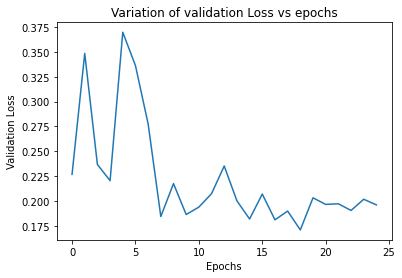

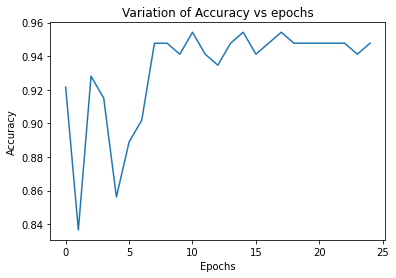

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


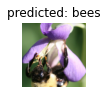

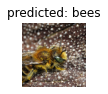

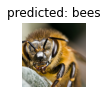

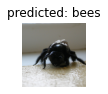

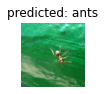

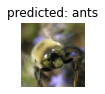

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()




---


---


# Task 1(d)


---



---



# Trying out other cases of CNN as fine-tuned feature extractor.

## Changing the training epochs (Keping all the other parameters same)


---





### Case 1 : Increasing the training epochs by 5

Epoch 0/29
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.5751 Acc: 0.7254
val Loss: 0.2035 Acc: 0.9150

Epoch 1/29
----------
train Loss: 0.4087 Acc: 0.8033
val Loss: 0.2805 Acc: 0.9150

Epoch 2/29
----------
train Loss: 0.3703 Acc: 0.8566
val Loss: 0.4341 Acc: 0.8562

Epoch 3/29
----------
train Loss: 0.5398 Acc: 0.7787
val Loss: 0.3086 Acc: 0.8824

Epoch 4/29
----------
train Loss: 0.5210 Acc: 0.7787
val Loss: 0.5922 Acc: 0.7974

Epoch 5/29
----------
train Loss: 0.3262 Acc: 0.8525
val Loss: 0.3969 Acc: 0.8693

Epoch 6/29
----------
train Loss: 0.3811 Acc: 0.8484
val Loss: 0.3590 Acc: 0.8693

Epoch 7/29
----------
train Loss: 0.5064 Acc: 0.8279
val Loss: 0.2311 Acc: 0.9216

Epoch 8/29
----------
train Loss: 0.2511 Acc: 0.9098
val Loss: 0.2123 Acc: 0.9346

Epoch 9/29
----------
train Loss: 0.2638 Acc: 0.8893
val Loss: 0.2180 Acc: 0.9412

Epoch 10/29
----------
train Loss: 0.2675 Acc: 0.8893
val Loss: 0.2059 Acc: 0.9281

Epoch 11/29
----------
train Loss: 0.2989 Acc: 0.8730
val Loss: 0.1993 Acc: 0.9412

Epoch 12/29
----------
t

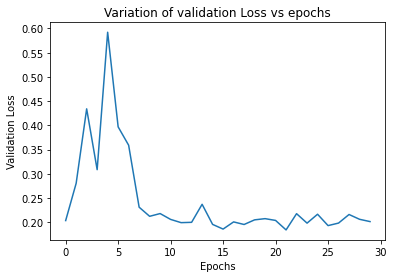

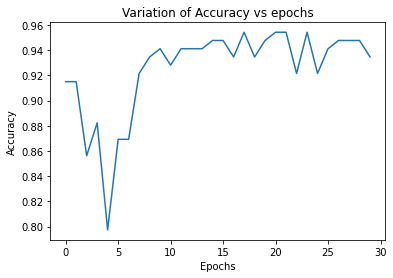

In [ ]:
model_ft_1_1 = models.resnet18(pretrained=True)
num_ftrs_1_1 = model_ft_1_1.fc.in_features

# Here the size of each output sample is set to 2.
model_ft_1_1.fc = nn.Linear(num_ftrs_1_1, 2)

model_ft_1_1 = model_ft_1_1.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft_1_1 = optim.SGD(model_ft_1_1.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft_1_1, step_size=7, gamma=0.1)

model_ft_1_1 = train_model(model_ft_1_1, criterion, optimizer_ft_1_1, exp_lr_scheduler, num_epochs=30)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


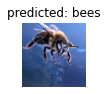

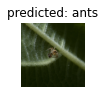

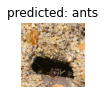

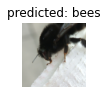

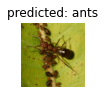

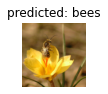

In [ ]:
visualize_model(model_ft_1_1)

plt.ioff()
plt.show()

### Case 2  : Decreasing the training epochs by 5

Epoch 0/19
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.2790 Acc: 0.8811
val Loss: 0.2235 Acc: 0.9216

Epoch 1/19
----------
train Loss: 0.2751 Acc: 0.8730
val Loss: 0.2244 Acc: 0.9477

Epoch 2/19
----------
train Loss: 0.3006 Acc: 0.8443
val Loss: 0.2101 Acc: 0.9412

Epoch 3/19
----------
train Loss: 0.2297 Acc: 0.9016
val Loss: 0.2403 Acc: 0.9412

Epoch 4/19
----------
train Loss: 0.2760 Acc: 0.8811
val Loss: 0.2215 Acc: 0.9542

Epoch 5/19
----------
train Loss: 0.2247 Acc: 0.9016
val Loss: 0.2377 Acc: 0.9477

Epoch 6/19
----------
train Loss: 0.2467 Acc: 0.8975
val Loss: 0.2194 Acc: 0.9477

Epoch 7/19
----------
train Loss: 0.1903 Acc: 0.9139
val Loss: 0.2159 Acc: 0.9477

Epoch 8/19
----------
train Loss: 0.3176 Acc: 0.8689
val Loss: 0.2149 Acc: 0.9477

Epoch 9/19
----------
train Loss: 0.2735 Acc: 0.8730
val Loss: 0.2167 Acc: 0.9542

Epoch 10/19
----------
train Loss: 0.3140 Acc: 0.8730
val Loss: 0.2215 Acc: 0.9412

Epoch 11/19
----------
train Loss: 0.2914 Acc: 0.9057
val Loss: 0.2209 Acc: 0.9412

Epoch 12/19
----------
t

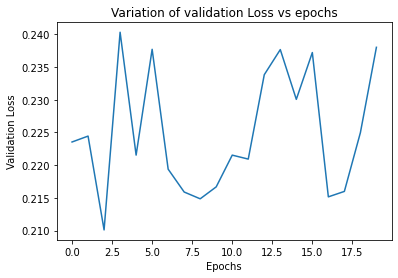

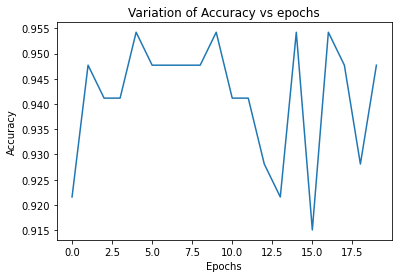

In [ ]:
model_ft_1_2 = models.resnet18(pretrained=True)
num_ftrs_1_2 = model_ft_1_2.fc.in_features

# Here the size of each output sample is set to 2.
model_ft_1_2.fc = nn.Linear(num_ftrs_1_2, 2)

model_ft_1_2 = model_ft_1_2.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft_1_2 = optim.SGD(model_ft_1_2.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft_1_2, step_size=7, gamma=0.1)

model_ft_1_2 = train_model(model_ft, criterion, optimizer_ft_1_2, exp_lr_scheduler, num_epochs=20)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


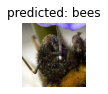

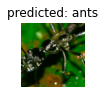

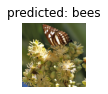

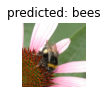

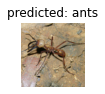

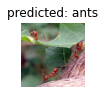

In [ ]:
visualize_model(model_ft_1_2)

plt.ioff()
plt.show()

### Case 3 : Decreasing the training epochs by 10

Epoch 0/14
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.2138 Acc: 0.9262
val Loss: 0.2157 Acc: 0.9542

Epoch 1/14
----------
train Loss: 0.2425 Acc: 0.9098
val Loss: 0.2272 Acc: 0.9477

Epoch 2/14
----------
train Loss: 0.2605 Acc: 0.8689
val Loss: 0.2397 Acc: 0.9477

Epoch 3/14
----------
train Loss: 0.2309 Acc: 0.9057
val Loss: 0.2189 Acc: 0.9477

Epoch 4/14
----------
train Loss: 0.1888 Acc: 0.9262
val Loss: 0.2306 Acc: 0.9346

Epoch 5/14
----------
train Loss: 0.3063 Acc: 0.8566
val Loss: 0.2198 Acc: 0.9477

Epoch 6/14
----------
train Loss: 0.3143 Acc: 0.8648
val Loss: 0.2201 Acc: 0.9477

Epoch 7/14
----------
train Loss: 0.3135 Acc: 0.8648
val Loss: 0.2444 Acc: 0.8954

Epoch 8/14
----------
train Loss: 0.2196 Acc: 0.9139
val Loss: 0.2132 Acc: 0.9477

Epoch 9/14
----------
train Loss: 0.2580 Acc: 0.9180
val Loss: 0.2162 Acc: 0.9542

Epoch 10/14
----------
train Loss: 0.3180 Acc: 0.8730
val Loss: 0.2197 Acc: 0.9412

Epoch 11/14
----------
train Loss: 0.3354 Acc: 0.8443
val Loss: 0.2273 Acc: 0.9477

Epoch 12/14
----------
t

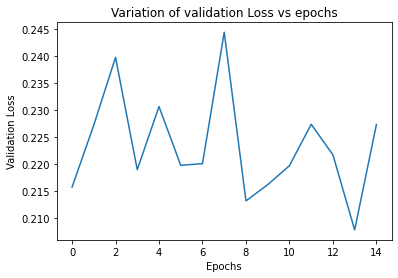

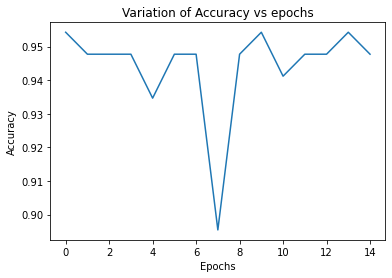

In [ ]:
model_ft_1_3 = models.resnet18(pretrained=True)
num_ftrs_1_3 = model_ft_1_3.fc.in_features

# Here the size of each output sample is set to 2.
model_ft_1_3.fc = nn.Linear(num_ftrs_1_3, 2)

model_ft_1_3 = model_ft_1_3.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft_1_3 = optim.SGD(model_ft_1_3.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft_1_3, step_size=7, gamma=0.1)

model_ft_1_3 = train_model(model_ft, criterion, optimizer_ft_1_3, exp_lr_scheduler, num_epochs=15)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


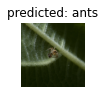

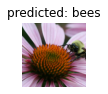

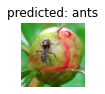

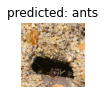

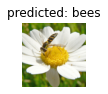

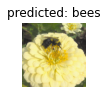

In [ ]:
visualize_model(model_ft_1_3)

plt.ioff()
plt.show()

## Changing the learning rate (Keeping other parameters the same)


---



### Case 1 (Using a smaller lr, 1/10 of original)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6752 Acc: 0.5656
val Loss: 0.4945 Acc: 0.8039

Epoch 1/24
----------
train Loss: 0.5876 Acc: 0.6598
val Loss: 0.4254 Acc: 0.8301

Epoch 2/24
----------
train Loss: 0.5308 Acc: 0.7049
val Loss: 0.3008 Acc: 0.8954

Epoch 3/24
----------
train Loss: 0.4134 Acc: 0.8279
val Loss: 0.2618 Acc: 0.9020

Epoch 4/24
----------
train Loss: 0.4195 Acc: 0.8156
val Loss: 0.2888 Acc: 0.8824

Epoch 5/24
----------
train Loss: 0.4231 Acc: 0.8033
val Loss: 0.2594 Acc: 0.8954

Epoch 6/24
----------
train Loss: 0.4181 Acc: 0.7869
val Loss: 0.2269 Acc: 0.9216

Epoch 7/24
----------
train Loss: 0.3632 Acc: 0.8443
val Loss: 0.2236 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.3458 Acc: 0.8689
val Loss: 0.2402 Acc: 0.8954

Epoch 9/24
----------
train Loss: 0.3295 Acc: 0.8811
val Loss: 0.2221 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.3347 Acc: 0.8443
val Loss: 0.2217 Acc: 0.9150

Epoch 11/24
----------
train Loss: 0.3417 Acc: 0.8607
val Loss: 0.2266 Acc: 0.9150

Epoch 12/24
----------
t

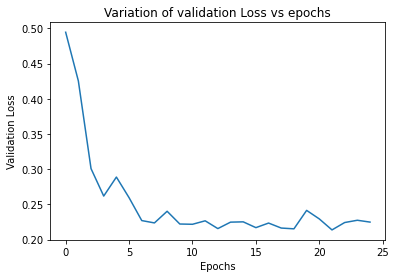

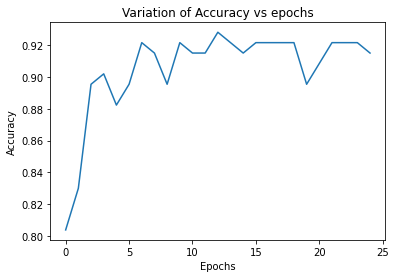

In [ ]:
model_ft_2_1 = models.resnet18(pretrained=True)
num_ftrs_2_1 = model_ft_2_1.fc.in_features

# Here the size of each output sample is set to 2.
model_ft_2_1.fc = nn.Linear(num_ftrs_2_1, 2)

model_ft_2_1 = model_ft_2_1.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft_2_1 = optim.SGD(model_ft_2_1.parameters(), lr=0.0001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft_2_1, step_size=7, gamma=0.1)

model_ft_2_1 = train_model(model_ft_2_1, criterion, optimizer_ft_2_1, exp_lr_scheduler, num_epochs=25)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


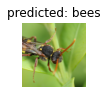

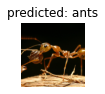

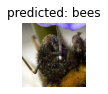

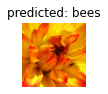

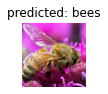

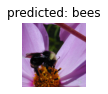

In [ ]:
visualize_model(model_ft_2_1)

plt.ioff()
plt.show()

### Case 2 (Using a larger lr, 5x of original)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 2.3821 Acc: 0.6066
val Loss: 4.3527 Acc: 0.5621

Epoch 1/24
----------
train Loss: 1.8022 Acc: 0.5246
val Loss: 1.6478 Acc: 0.4641

Epoch 2/24
----------
train Loss: 1.5642 Acc: 0.5123
val Loss: 3.3901 Acc: 0.5948

Epoch 3/24
----------
train Loss: 1.2387 Acc: 0.5041
val Loss: 0.9367 Acc: 0.6144

Epoch 4/24
----------
train Loss: 1.6269 Acc: 0.5738
val Loss: 1.1230 Acc: 0.5752

Epoch 5/24
----------
train Loss: 1.0144 Acc: 0.5574
val Loss: 1.8473 Acc: 0.5098

Epoch 6/24
----------
train Loss: 1.0400 Acc: 0.5779
val Loss: 0.6347 Acc: 0.5882

Epoch 7/24
----------
train Loss: 0.6896 Acc: 0.5861
val Loss: 0.9376 Acc: 0.6078

Epoch 8/24
----------
train Loss: 0.6461 Acc: 0.6311
val Loss: 0.6724 Acc: 0.7516

Epoch 9/24
----------
train Loss: 0.6703 Acc: 0.6393
val Loss: 0.6217 Acc: 0.7516

Epoch 10/24
----------
train Loss: 0.6578 Acc: 0.6148
val Loss: 0.6911 Acc: 0.6144

Epoch 11/24
----------
train Loss: 0.6738 Acc: 0.6066
val Loss: 0.6386 Acc: 0.6732

Epoch 12/24
----------
t

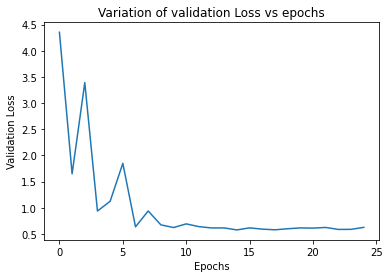

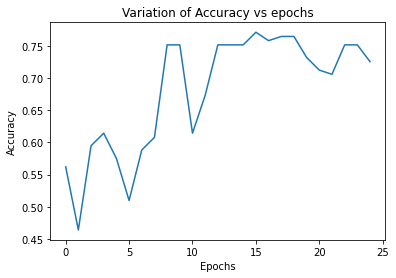

In [ ]:
model_ft_2_2 = models.resnet18(pretrained=True)
num_ftrs_2_2 = model_ft_2_2.fc.in_features

# Here the size of each output sample is set to 2.
model_ft_2_2.fc = nn.Linear(num_ftrs_2_2, 2)

model_ft_2_2 = model_ft_2_2.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft_2_2 = optim.SGD(model_ft_2_2.parameters(), lr=0.005, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft_2_2, step_size=7, gamma=0.1)

model_ft_2_2 = train_model(model_ft_2_2, criterion, optimizer_ft_2_2, exp_lr_scheduler, num_epochs=25)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


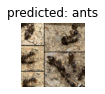

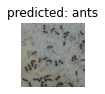

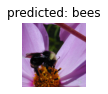

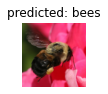

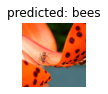

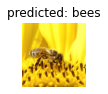

In [ ]:
visualize_model(model_ft_2_2)

plt.ioff()
plt.show()

### Case 3 (Using a more large lr, 10x of original)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 4.7760 Acc: 0.4959
val Loss: 1.3383 Acc: 0.4706

Epoch 1/24
----------
train Loss: 2.4084 Acc: 0.5082
val Loss: 2.7159 Acc: 0.4837

Epoch 2/24
----------
train Loss: 1.8509 Acc: 0.5410
val Loss: 19.3404 Acc: 0.4575

Epoch 3/24
----------
train Loss: 1.6605 Acc: 0.5615
val Loss: 3.3605 Acc: 0.4641

Epoch 4/24
----------
train Loss: 1.0377 Acc: 0.5123
val Loss: 6.6185 Acc: 0.6013

Epoch 5/24
----------
train Loss: 0.9624 Acc: 0.5328
val Loss: 23.8059 Acc: 0.5425

Epoch 6/24
----------
train Loss: 1.7266 Acc: 0.5615
val Loss: 181.1661 Acc: 0.4575

Epoch 7/24
----------
train Loss: 0.8399 Acc: 0.5574
val Loss: 2.1036 Acc: 0.5556

Epoch 8/24
----------
train Loss: 0.7346 Acc: 0.5492
val Loss: 3.5922 Acc: 0.4575

Epoch 9/24
----------
train Loss: 0.7486 Acc: 0.5369
val Loss: 1.2780 Acc: 0.5621

Epoch 10/24
----------
train Loss: 0.7436 Acc: 0.5410
val Loss: 1.0182 Acc: 0.5425

Epoch 11/24
----------
train Loss: 0.8172 Acc: 0.5615
val Loss: 17.1704 Acc: 0.4575

Epoch 12/24
-------

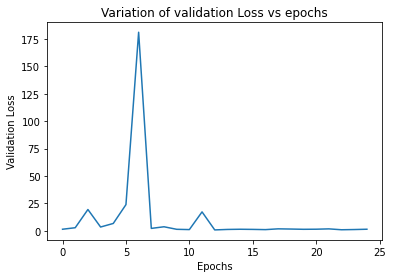

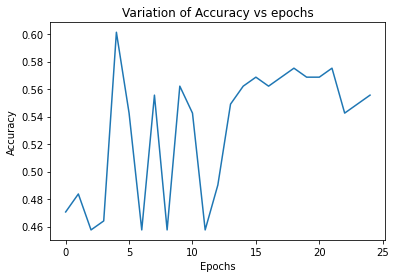

In [ ]:
model_ft_2_3 = models.resnet18(pretrained=True)
num_ftrs_2_3 = model_ft_2_3.fc.in_features

# Here the size of each output sample is set to 2.
model_ft_2_3.fc = nn.Linear(num_ftrs_2_3, 2)

model_ft_2_3 = model_ft_2_3.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft_2_3 = optim.SGD(model_ft_2_3.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft_2_3, step_size=7, gamma=0.1)

model_ft_2_3 = train_model(model_ft_2_3, criterion, optimizer_ft_2_3, exp_lr_scheduler, num_epochs=25)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


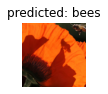

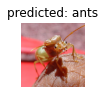

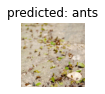

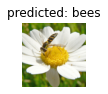

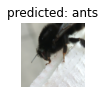

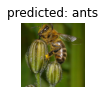

In [ ]:
visualize_model(model_ft_2_3)

plt.ioff()
plt.show()

## Changing the momentum (Keeping the other parameters the same)


---



### Case 1 (Lesser momentum of 0.3)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6477 Acc: 0.6107
val Loss: 0.4262 Acc: 0.8497

Epoch 1/24
----------
train Loss: 0.4252 Acc: 0.8443
val Loss: 0.3125 Acc: 0.8954

Epoch 2/24
----------
train Loss: 0.4130 Acc: 0.8320
val Loss: 0.2464 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.4137 Acc: 0.8238
val Loss: 0.2222 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.3922 Acc: 0.8320
val Loss: 0.2161 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.3753 Acc: 0.7992
val Loss: 0.2006 Acc: 0.9346

Epoch 6/24
----------
train Loss: 0.3450 Acc: 0.8361
val Loss: 0.1792 Acc: 0.9346

Epoch 7/24
----------
train Loss: 0.3370 Acc: 0.8402
val Loss: 0.1815 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3925 Acc: 0.8197
val Loss: 0.2173 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.3357 Acc: 0.8443
val Loss: 0.1997 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.2901 Acc: 0.9180
val Loss: 0.1838 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3275 Acc: 0.8648
val Loss: 0.2015 Acc: 0.9346

Epoch 12/24
----------
t

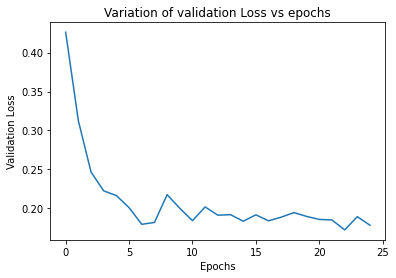

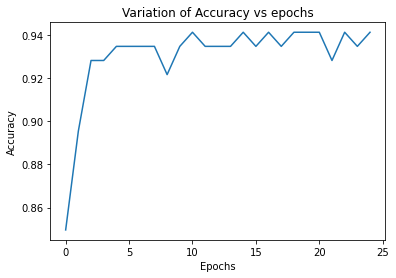

In [ ]:
model_ft_3_1 = models.resnet18(pretrained=True)
num_ftrs_3_1 = model_ft_3_1.fc.in_features

# Here the size of each output sample is set to 2.
model_ft_3_1.fc = nn.Linear(num_ftrs_3_1, 2)

model_ft_3_1 = model_ft_3_1.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft_3_1 = optim.SGD(model_ft_3_1.parameters(), lr=0.001, momentum=0.3)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft_3_1, step_size=7, gamma=0.1)

model_ft_3_1 = train_model(model_ft_3_1, criterion, optimizer_ft_3_1, exp_lr_scheduler, num_epochs=25)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


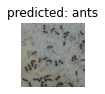

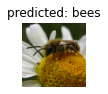

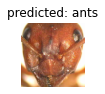

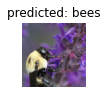

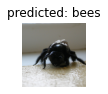

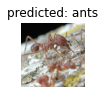

In [ ]:
visualize_model(model_ft_3_1)

plt.ioff()
plt.show()

### Case 2  (Lesser momentum of 0.6)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.5971 Acc: 0.6885
val Loss: 0.3058 Acc: 0.9020

Epoch 1/24
----------
train Loss: 0.4577 Acc: 0.8115
val Loss: 0.2811 Acc: 0.8824

Epoch 2/24
----------
train Loss: 0.3907 Acc: 0.7951
val Loss: 0.1977 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.3453 Acc: 0.8525
val Loss: 0.1945 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.3519 Acc: 0.8525
val Loss: 0.1895 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.3320 Acc: 0.8484
val Loss: 0.1566 Acc: 0.9542

Epoch 6/24
----------
train Loss: 0.3678 Acc: 0.8115
val Loss: 0.1718 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.3606 Acc: 0.8484
val Loss: 0.1794 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3135 Acc: 0.8730
val Loss: 0.1606 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3098 Acc: 0.8607
val Loss: 0.1543 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.2841 Acc: 0.8934
val Loss: 0.1623 Acc: 0.9608

Epoch 11/24
----------
train Loss: 0.3513 Acc: 0.8484
val Loss: 0.1590 Acc: 0.9608

Epoch 12/24
----------
t

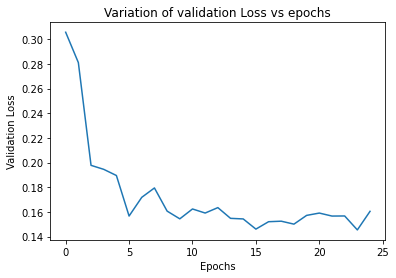

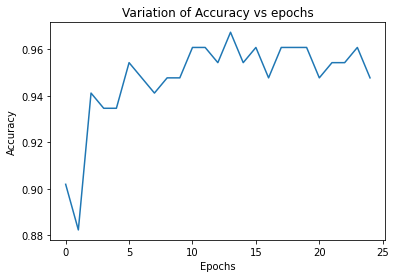

In [ ]:
model_ft_3_2 = models.resnet18(pretrained=True)
num_ftrs_3_2 = model_ft_3_2.fc.in_features

# Here the size of each output sample is set to 2.
model_ft_3_2.fc = nn.Linear(num_ftrs_3_2, 2)

model_ft_3_2 = model_ft_3_2.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft_3_2 = optim.SGD(model_ft_3_2.parameters(), lr=0.001, momentum=0.6)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft_3_2, step_size=7, gamma=0.1)

model_ft_3_2 = train_model(model_ft_3_2, criterion, optimizer_ft_3_2, exp_lr_scheduler, num_epochs=25)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


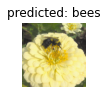

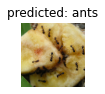

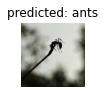

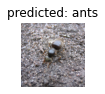

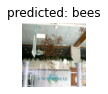

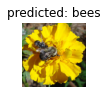

In [ ]:
visualize_model(model_ft_3_2)

plt.ioff()
plt.show()

### Case 3 (Higeher momentum of 0.99)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.8691 Acc: 0.7008
val Loss: 2.1511 Acc: 0.7190

Epoch 1/24
----------
train Loss: 1.8060 Acc: 0.5943
val Loss: 13.0082 Acc: 0.3856

Epoch 2/24
----------
train Loss: 1.8563 Acc: 0.5041
val Loss: 2.8870 Acc: 0.5229

Epoch 3/24
----------
train Loss: 1.5949 Acc: 0.5369
val Loss: 3.8586 Acc: 0.5686

Epoch 4/24
----------
train Loss: 1.6467 Acc: 0.5943
val Loss: 12.1433 Acc: 0.5425

Epoch 5/24
----------
train Loss: 2.5528 Acc: 0.5205
val Loss: 51.2132 Acc: 0.4575

Epoch 6/24
----------
train Loss: 1.9562 Acc: 0.5533
val Loss: 1.8466 Acc: 0.5882

Epoch 7/24
----------
train Loss: 1.0321 Acc: 0.5082
val Loss: 1.5452 Acc: 0.5163

Epoch 8/24
----------
train Loss: 0.8282 Acc: 0.5082
val Loss: 3.6170 Acc: 0.5686

Epoch 9/24
----------
train Loss: 0.9157 Acc: 0.5246
val Loss: 2.7261 Acc: 0.5621

Epoch 10/24
----------
train Loss: 0.7227 Acc: 0.5164
val Loss: 2.5445 Acc: 0.5359

Epoch 11/24
----------
train Loss: 0.7922 Acc: 0.5164
val Loss: 4.5634 Acc: 0.5752

Epoch 12/24
---------

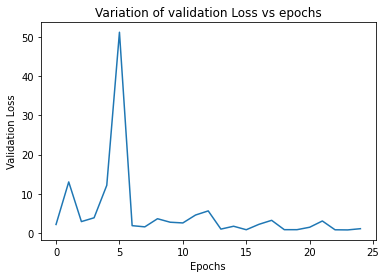

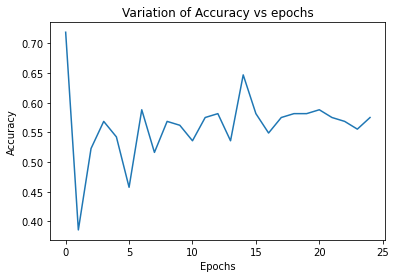

In [ ]:
model_ft_3_3 = models.resnet18(pretrained=True)
num_ftrs_3_3 = model_ft_3_3.fc.in_features

# Here the size of each output sample is set to 2.
model_ft_3_3.fc = nn.Linear(num_ftrs_3_3, 2)

model_ft_3_3 = model_ft_3_3.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft_3_3 = optim.SGD(model_ft_3_3.parameters(), lr=0.001, momentum=0.99)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft_3_3, step_size=7, gamma=0.1)

model_ft_3_3 = train_model(model_ft_3_3, criterion, optimizer_ft_3_3, exp_lr_scheduler, num_epochs=25)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


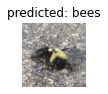

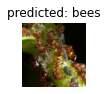

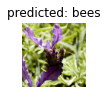

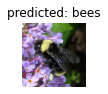

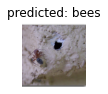

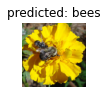

In [ ]:
visualize_model(model_ft_3_3)

plt.ioff()
plt.show()



---



# Trying out other cases for CNN as Fixed feature extractor.

## Changing the training epochs (Keping all the other parameters same)


---



### Case 1 : Increasing the training epochs by 5

Epoch 0/29
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6892 Acc: 0.6148
val Loss: 0.2730 Acc: 0.8889

Epoch 1/29
----------
train Loss: 0.4774 Acc: 0.8115
val Loss: 0.2127 Acc: 0.9346

Epoch 2/29
----------
train Loss: 0.4706 Acc: 0.7705
val Loss: 0.2541 Acc: 0.9216

Epoch 3/29
----------
train Loss: 0.4662 Acc: 0.8074
val Loss: 0.3396 Acc: 0.8758

Epoch 4/29
----------
train Loss: 0.6555 Acc: 0.7418
val Loss: 0.2438 Acc: 0.9281

Epoch 5/29
----------
train Loss: 0.4539 Acc: 0.8320
val Loss: 0.2306 Acc: 0.9281

Epoch 6/29
----------
train Loss: 0.3676 Acc: 0.8730
val Loss: 0.2119 Acc: 0.9150

Epoch 7/29
----------
train Loss: 0.4212 Acc: 0.8033
val Loss: 0.2203 Acc: 0.9412

Epoch 8/29
----------
train Loss: 0.3923 Acc: 0.8197
val Loss: 0.1908 Acc: 0.9281

Epoch 9/29
----------
train Loss: 0.3806 Acc: 0.8197
val Loss: 0.2117 Acc: 0.9216

Epoch 10/29
----------
train Loss: 0.3616 Acc: 0.8484
val Loss: 0.2020 Acc: 0.9412

Epoch 11/29
----------
train Loss: 0.3851 Acc: 0.8238
val Loss: 0.1907 Acc: 0.9412

Epoch 12/29
----------
t

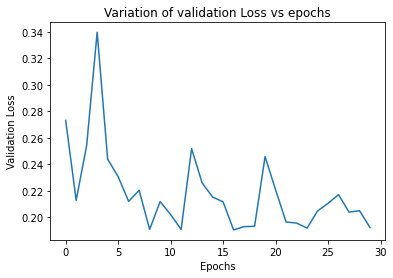

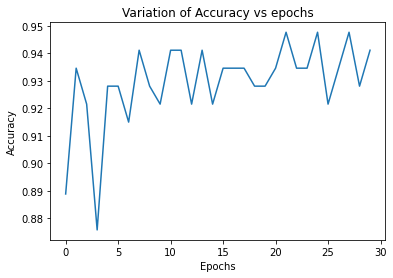

In [ ]:
model_conv_1_1 = torchvision.models.resnet18(pretrained=True)
for param in model_conv_1_1.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs_1_1 = model_conv_1_1.fc.in_features
model_conv_1_1.fc = nn.Linear(num_ftrs_1_1, 2)

model_conv_1_1 = model_conv_1_1.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv_1_1 = optim.SGD(model_conv_1_1.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv_1_1, step_size=7, gamma=0.1)

model_conv_1_1 = train_model(model_conv_1_1, criterion, optimizer_conv_1_1, exp_lr_scheduler, num_epochs=30)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


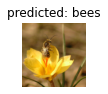

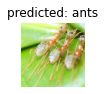

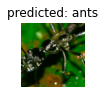

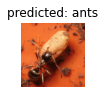

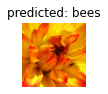

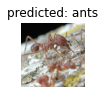

In [ ]:
visualize_model(model_conv_1_1)

plt.ioff()
plt.show()

### Case 2  : Decreasing the training epochs by 5

Epoch 0/19
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.5698 Acc: 0.6762
val Loss: 0.2982 Acc: 0.8693

Epoch 1/19
----------
train Loss: 0.6602 Acc: 0.7090
val Loss: 0.2718 Acc: 0.8889

Epoch 2/19
----------
train Loss: 0.5720 Acc: 0.7500
val Loss: 0.1605 Acc: 0.9542

Epoch 3/19
----------
train Loss: 0.3531 Acc: 0.8402
val Loss: 0.1934 Acc: 0.9346

Epoch 4/19
----------
train Loss: 0.5384 Acc: 0.7910
val Loss: 0.1551 Acc: 0.9542

Epoch 5/19
----------
train Loss: 0.4953 Acc: 0.7869
val Loss: 0.1545 Acc: 0.9542

Epoch 6/19
----------
train Loss: 0.4881 Acc: 0.7951
val Loss: 0.1745 Acc: 0.9412

Epoch 7/19
----------
train Loss: 0.3320 Acc: 0.8566
val Loss: 0.1691 Acc: 0.9608

Epoch 8/19
----------
train Loss: 0.3115 Acc: 0.8566
val Loss: 0.1637 Acc: 0.9412

Epoch 9/19
----------
train Loss: 0.3912 Acc: 0.8197
val Loss: 0.1705 Acc: 0.9477

Epoch 10/19
----------
train Loss: 0.3393 Acc: 0.8484
val Loss: 0.1671 Acc: 0.9542

Epoch 11/19
----------
train Loss: 0.3340 Acc: 0.8320
val Loss: 0.1815 Acc: 0.9542

Epoch 12/19
----------
t

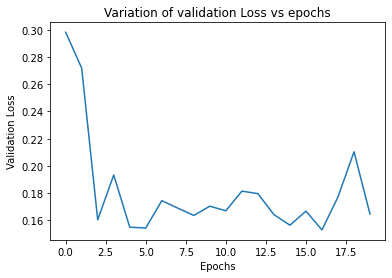

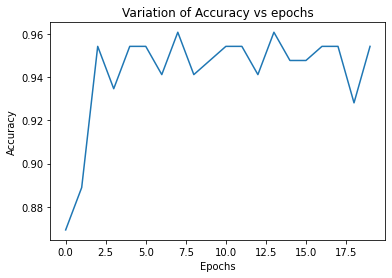

In [ ]:
model_conv_1_2 = torchvision.models.resnet18(pretrained=True)
for param in model_conv_1_2.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs_1_2 = model_conv_1_2.fc.in_features
model_conv_1_2.fc = nn.Linear(num_ftrs_1_2, 2)

model_conv_1_2 = model_conv_1_2.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv_1_2 = optim.SGD(model_conv_1_2.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv_1_2, step_size=7, gamma=0.1)

model_conv_1_2 = train_model(model_conv_1_2, criterion, optimizer_conv_1_2, exp_lr_scheduler, num_epochs=20)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


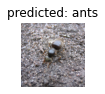

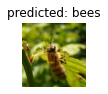

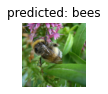

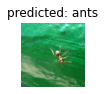

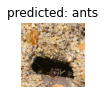

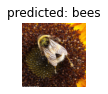

In [ ]:
visualize_model(model_conv_1_2)

plt.ioff()
plt.show()

### Case 3 : Decreasing the training epochs by 10

Epoch 0/14
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.5820 Acc: 0.6844
val Loss: 0.3240 Acc: 0.8431

Epoch 1/14
----------
train Loss: 0.3453 Acc: 0.8525
val Loss: 0.3301 Acc: 0.8627

Epoch 2/14
----------
train Loss: 0.5876 Acc: 0.7541
val Loss: 0.1819 Acc: 0.9542

Epoch 3/14
----------
train Loss: 0.4214 Acc: 0.7992
val Loss: 0.2568 Acc: 0.9020

Epoch 4/14
----------
train Loss: 0.4964 Acc: 0.7992
val Loss: 0.1934 Acc: 0.9216

Epoch 5/14
----------
train Loss: 0.2908 Acc: 0.8811
val Loss: 0.2112 Acc: 0.9281

Epoch 6/14
----------
train Loss: 0.4366 Acc: 0.7951
val Loss: 0.2997 Acc: 0.8954

Epoch 7/14
----------
train Loss: 0.4120 Acc: 0.7992
val Loss: 0.1960 Acc: 0.9216

Epoch 8/14
----------
train Loss: 0.4399 Acc: 0.8197
val Loss: 0.2165 Acc: 0.9281

Epoch 9/14
----------
train Loss: 0.3464 Acc: 0.8607
val Loss: 0.1881 Acc: 0.9346

Epoch 10/14
----------
train Loss: 0.3332 Acc: 0.8484
val Loss: 0.2226 Acc: 0.9281

Epoch 11/14
----------
train Loss: 0.3380 Acc: 0.8525
val Loss: 0.1836 Acc: 0.9281

Epoch 12/14
----------
t

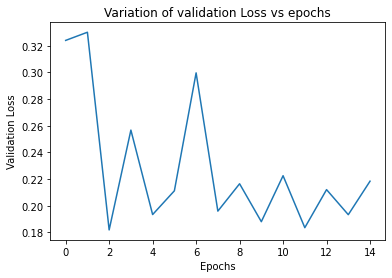

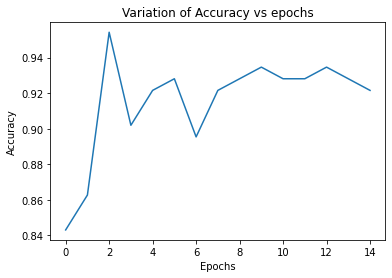

In [ ]:
model_conv_1_3 = torchvision.models.resnet18(pretrained=True)
for param in model_conv_1_3.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs_1_3 = model_conv_1_3.fc.in_features
model_conv_1_3.fc = nn.Linear(num_ftrs_1_3, 2)

model_conv_1_3 = model_conv_1_3.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv_1_3 = optim.SGD(model_conv_1_3.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv_1_3, step_size=7, gamma=0.1)

model_conv_1_3 = train_model(model_conv_1_3, criterion, optimizer_conv_1_3, exp_lr_scheduler, num_epochs=15)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


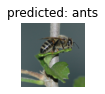

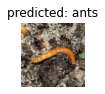

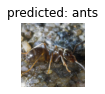

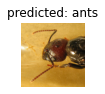

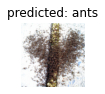

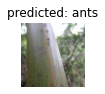

In [ ]:
visualize_model(model_conv_1_3)

plt.ioff()
plt.show()

## Changing the learning rate (Keeping other parameters the same)


---



### Case 1 (Using a smaller lr, 1/10 of original)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.7397 Acc: 0.5246
val Loss: 0.6143 Acc: 0.6340

Epoch 1/24
----------
train Loss: 0.6460 Acc: 0.5861
val Loss: 0.5043 Acc: 0.7647

Epoch 2/24
----------
train Loss: 0.5297 Acc: 0.7459
val Loss: 0.4109 Acc: 0.8562

Epoch 3/24
----------
train Loss: 0.5108 Acc: 0.7787
val Loss: 0.3368 Acc: 0.9020

Epoch 4/24
----------
train Loss: 0.4771 Acc: 0.7664
val Loss: 0.3422 Acc: 0.8889

Epoch 5/24
----------
train Loss: 0.4564 Acc: 0.7828
val Loss: 0.3044 Acc: 0.9020

Epoch 6/24
----------
train Loss: 0.4345 Acc: 0.8279
val Loss: 0.2732 Acc: 0.9150

Epoch 7/24
----------
train Loss: 0.4792 Acc: 0.7869
val Loss: 0.2913 Acc: 0.9020

Epoch 8/24
----------
train Loss: 0.4245 Acc: 0.8238
val Loss: 0.2706 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.4151 Acc: 0.8279
val Loss: 0.2885 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.4323 Acc: 0.7992
val Loss: 0.2621 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.4419 Acc: 0.8074
val Loss: 0.2694 Acc: 0.9216

Epoch 12/24
----------
t

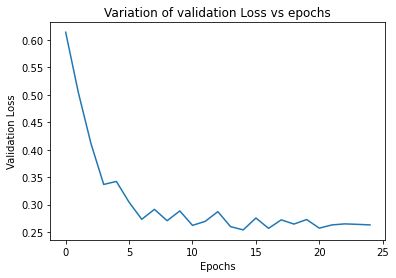

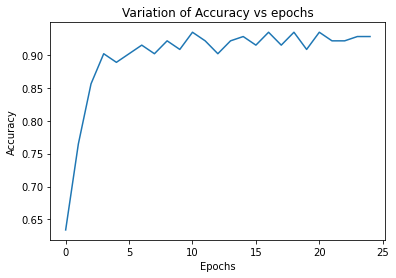

In [ ]:
model_conv_2_1 = torchvision.models.resnet18(pretrained=True)
for param in model_conv_2_1.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs_2_1 = model_conv_2_1.fc.in_features
model_conv_2_1.fc = nn.Linear(num_ftrs_2_1, 2)

model_conv_2_1 = model_conv_2_1.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv_2_1 = optim.SGD(model_conv_2_1.fc.parameters(), lr=0.0001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv_2_1, step_size=7, gamma=0.1)

model_conv_2_1 = train_model(model_conv_2_1, criterion, optimizer_conv_2_1, exp_lr_scheduler, num_epochs=25)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


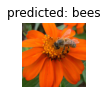

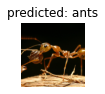

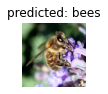

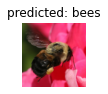

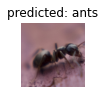

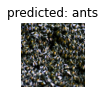

In [ ]:
visualize_model(model_conv_2_1)

plt.ioff()
plt.show()

### Case 2 (Using a larger lr, 5x of original)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 1.1551 Acc: 0.7131
val Loss: 0.4265 Acc: 0.8954

Epoch 1/24
----------
train Loss: 1.1897 Acc: 0.7500
val Loss: 0.2157 Acc: 0.9346

Epoch 2/24
----------
train Loss: 3.4869 Acc: 0.5861
val Loss: 1.1491 Acc: 0.8497

Epoch 3/24
----------
train Loss: 1.9733 Acc: 0.7746
val Loss: 0.5517 Acc: 0.9346

Epoch 4/24
----------
train Loss: 1.4759 Acc: 0.7746
val Loss: 0.4012 Acc: 0.9477

Epoch 5/24
----------
train Loss: 1.9184 Acc: 0.7336
val Loss: 0.4757 Acc: 0.9346

Epoch 6/24
----------
train Loss: 1.0624 Acc: 0.8115
val Loss: 0.4806 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.9020 Acc: 0.8320
val Loss: 0.4922 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.7131 Acc: 0.8525
val Loss: 0.7082 Acc: 0.9085

Epoch 9/24
----------
train Loss: 1.5400 Acc: 0.7500
val Loss: 0.5689 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.6486 Acc: 0.8689
val Loss: 0.6423 Acc: 0.8954

Epoch 11/24
----------
train Loss: 0.5162 Acc: 0.8730
val Loss: 0.5134 Acc: 0.9085

Epoch 12/24
----------
t

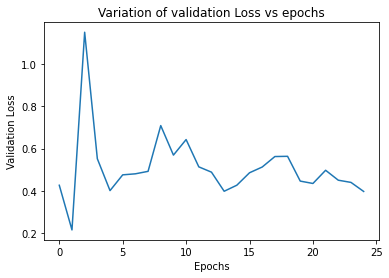

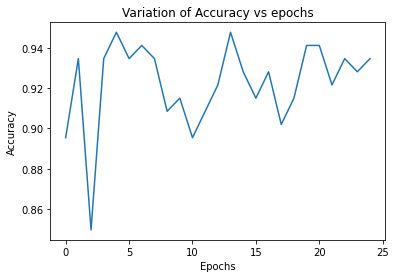

In [ ]:
model_conv_2_2 = torchvision.models.resnet18(pretrained=True)
for param in model_conv_2_2.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs_2_2 = model_conv_2_2.fc.in_features
model_conv_2_2.fc = nn.Linear(num_ftrs_2_2, 2)

model_conv_2_2 = model_conv_2_2.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv_2_2 = optim.SGD(model_conv_2_2.fc.parameters(), lr=0.005, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv_2_2, step_size=7, gamma=0.1)

model_conv_2_2 = train_model(model_conv_2_2, criterion, optimizer_conv_2_2, exp_lr_scheduler, num_epochs=25)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


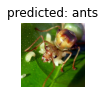

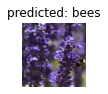

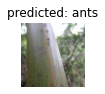

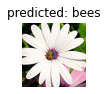

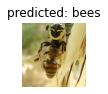

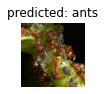

In [ ]:
visualize_model(model_conv_2_2)

plt.ioff()
plt.show()

### Case 3 (Using a more large lr, 10x of original)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 2.2393 Acc: 0.6721
val Loss: 0.7149 Acc: 0.8758

Epoch 1/24
----------
train Loss: 1.7013 Acc: 0.7951
val Loss: 0.8481 Acc: 0.9020

Epoch 2/24
----------
train Loss: 2.3645 Acc: 0.7541
val Loss: 0.5690 Acc: 0.9346

Epoch 3/24
----------
train Loss: 1.7687 Acc: 0.8402
val Loss: 0.9141 Acc: 0.9281

Epoch 4/24
----------
train Loss: 1.8964 Acc: 0.7910
val Loss: 0.6713 Acc: 0.9542

Epoch 5/24
----------
train Loss: 2.2568 Acc: 0.8033
val Loss: 1.1920 Acc: 0.9085

Epoch 6/24
----------
train Loss: 3.9295 Acc: 0.7664
val Loss: 0.9071 Acc: 0.9346

Epoch 7/24
----------
train Loss: 1.9473 Acc: 0.8197
val Loss: 0.9870 Acc: 0.9412

Epoch 8/24
----------
train Loss: 1.0919 Acc: 0.8811
val Loss: 0.9191 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.9299 Acc: 0.8934
val Loss: 1.0270 Acc: 0.9346

Epoch 10/24
----------
train Loss: 1.7785 Acc: 0.8484
val Loss: 0.9213 Acc: 0.9346

Epoch 11/24
----------
train Loss: 1.4386 Acc: 0.8484
val Loss: 1.0535 Acc: 0.9412

Epoch 12/24
----------
t

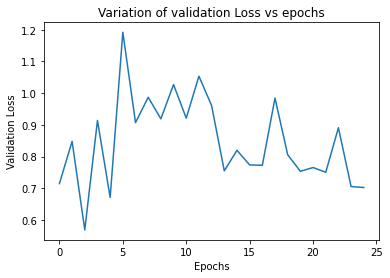

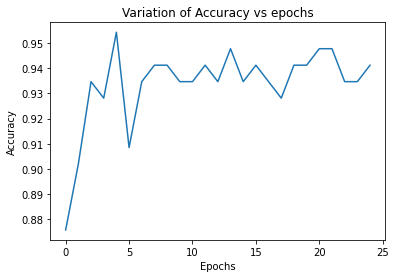

In [ ]:
model_conv_2_3 = torchvision.models.resnet18(pretrained=True)
for param in model_conv_2_3.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs_2_3 = model_conv_2_3.fc.in_features
model_conv_2_3.fc = nn.Linear(num_ftrs_2_3, 2)

model_conv_2_3 = model_conv_2_3.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv_2_3 = optim.SGD(model_conv_2_3.fc.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv_2_3, step_size=7, gamma=0.1)

model_conv_2_3 = train_model(model_conv_2_3, criterion, optimizer_conv_2_3, exp_lr_scheduler, num_epochs=25)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


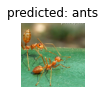

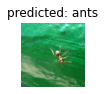

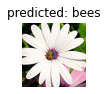

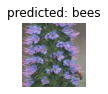

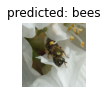

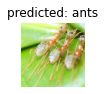

In [ ]:
visualize_model(model_conv_2_3)

plt.ioff()
plt.show()

## Changing the momentum (Keeping the other parameters the same)


---



### Case 1 (Lesser momentum of 0.3)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6302 Acc: 0.6803
val Loss: 0.4138 Acc: 0.8889

Epoch 1/24
----------
train Loss: 0.5636 Acc: 0.7131
val Loss: 0.3450 Acc: 0.9020

Epoch 2/24
----------
train Loss: 0.4971 Acc: 0.7664
val Loss: 0.3125 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.4766 Acc: 0.8115
val Loss: 0.2848 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.4665 Acc: 0.7787
val Loss: 0.2343 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.4334 Acc: 0.8115
val Loss: 0.2572 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.4432 Acc: 0.8033
val Loss: 0.2189 Acc: 0.9542

Epoch 7/24
----------
train Loss: 0.4050 Acc: 0.8156
val Loss: 0.2244 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.4076 Acc: 0.8320
val Loss: 0.2238 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3644 Acc: 0.8484
val Loss: 0.2128 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.4058 Acc: 0.8115
val Loss: 0.2206 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3674 Acc: 0.8525
val Loss: 0.2175 Acc: 0.9542

Epoch 12/24
----------
t

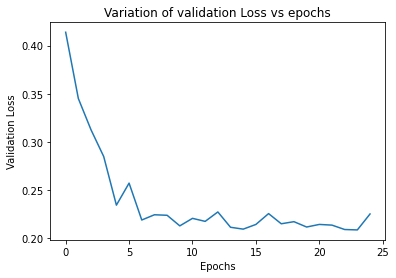

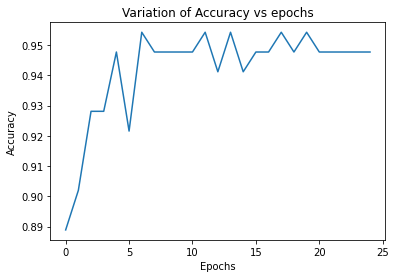

In [ ]:
model_conv_3_1 = torchvision.models.resnet18(pretrained=True)
for param in model_conv_3_1.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs_3_1 = model_conv_3_1.fc.in_features
model_conv_3_1.fc = nn.Linear(num_ftrs_3_1, 2)

model_conv_3_1 = model_conv_3_1.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv_3_1 = optim.SGD(model_conv_3_1.fc.parameters(), lr=0.001, momentum=0.3)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv_3_1, step_size=7, gamma=0.1)

model_conv_3_1 = train_model(model_conv_3_1, criterion, optimizer_conv_3_1, exp_lr_scheduler, num_epochs=25)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


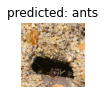

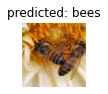

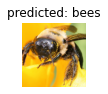

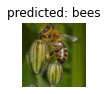

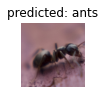

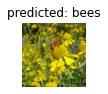

In [ ]:
visualize_model(model_conv_3_1)

plt.ioff()
plt.show()

### Case 2  (Lesser momentum of 0.6)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6374 Acc: 0.6680
val Loss: 0.5409 Acc: 0.6471

Epoch 1/24
----------
train Loss: 0.5026 Acc: 0.7828
val Loss: 0.3483 Acc: 0.8693

Epoch 2/24
----------
train Loss: 0.4995 Acc: 0.7664
val Loss: 0.2417 Acc: 0.9216

Epoch 3/24
----------
train Loss: 0.4329 Acc: 0.8074
val Loss: 0.2276 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.4691 Acc: 0.7787
val Loss: 0.2349 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.3819 Acc: 0.8361
val Loss: 0.1835 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.4683 Acc: 0.7664
val Loss: 0.1920 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.4226 Acc: 0.7992
val Loss: 0.2141 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3663 Acc: 0.8361
val Loss: 0.1954 Acc: 0.9542

Epoch 9/24
----------
train Loss: 0.3593 Acc: 0.8525
val Loss: 0.1935 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3527 Acc: 0.8484
val Loss: 0.2034 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3709 Acc: 0.8402
val Loss: 0.1984 Acc: 0.9477

Epoch 12/24
----------
t

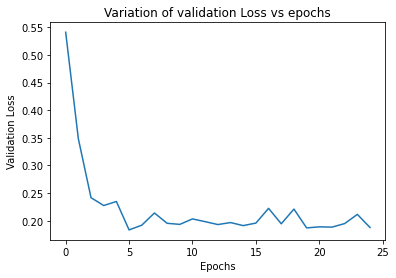

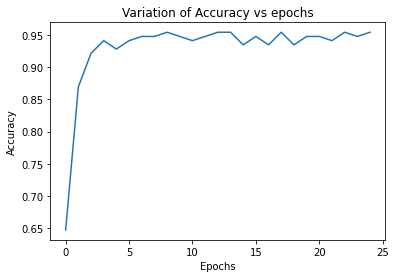

In [ ]:
model_conv_3_2 = torchvision.models.resnet18(pretrained=True)
for param in model_conv_3_2.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs_3_2 = model_conv_3_2.fc.in_features
model_conv_3_2.fc = nn.Linear(num_ftrs_3_2, 2)

model_conv_3_2 = model_conv_3_2.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv_3_2 = optim.SGD(model_conv_3_2.fc.parameters(), lr=0.001, momentum=0.6)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv_3_2, step_size=7, gamma=0.1)

model_conv_3_2 = train_model(model_conv_3_2, criterion, optimizer_conv_3_2, exp_lr_scheduler, num_epochs=25)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


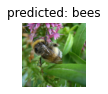

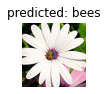

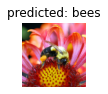

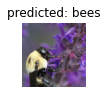

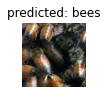

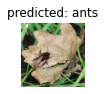

In [ ]:
visualize_model(model_conv_3_2)

plt.ioff()
plt.show()

### Case 3 (Higeher momentum of 0.99)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6430 Acc: 0.6803
val Loss: 0.3116 Acc: 0.8954

Epoch 1/24
----------
train Loss: 0.6919 Acc: 0.8074
val Loss: 0.5956 Acc: 0.8889

Epoch 2/24
----------
train Loss: 0.6305 Acc: 0.8238
val Loss: 0.6186 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.9175 Acc: 0.8279
val Loss: 0.4916 Acc: 0.9542

Epoch 4/24
----------
train Loss: 1.3571 Acc: 0.7623
val Loss: 0.5232 Acc: 0.9477

Epoch 5/24
----------
train Loss: 1.2148 Acc: 0.8443
val Loss: 0.5124 Acc: 0.9150

Epoch 6/24
----------
train Loss: 1.6506 Acc: 0.7295
val Loss: 0.8345 Acc: 0.8889

Epoch 7/24
----------
train Loss: 0.6811 Acc: 0.8607
val Loss: 0.6402 Acc: 0.8954

Epoch 8/24
----------
train Loss: 1.0135 Acc: 0.7787
val Loss: 1.2255 Acc: 0.8627

Epoch 9/24
----------
train Loss: 0.5477 Acc: 0.8934
val Loss: 0.6730 Acc: 0.8954

Epoch 10/24
----------
train Loss: 0.6331 Acc: 0.8525
val Loss: 0.5931 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.5922 Acc: 0.8525
val Loss: 0.5964 Acc: 0.9150

Epoch 12/24
----------
t

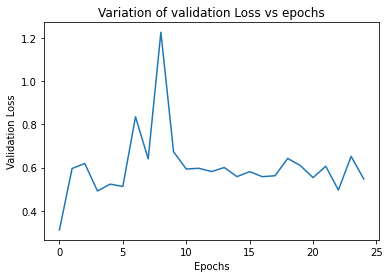

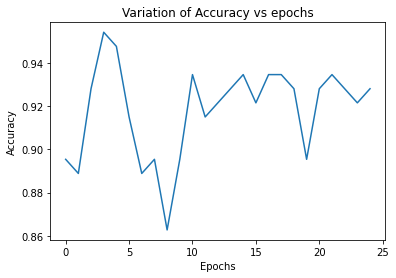

In [ ]:
model_conv_3_3 = torchvision.models.resnet18(pretrained=True)
for param in model_conv_3_3.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs_3_3 = model_conv_3_3.fc.in_features
model_conv_3_3.fc = nn.Linear(num_ftrs_3_3, 2)

model_conv_3_3 = model_conv_3_3.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv_3_3 = optim.SGD(model_conv_3_3.fc.parameters(), lr=0.001, momentum=0.99)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv_3_3, step_size=7, gamma=0.1)

model_conv_3_3 = train_model(model_conv_3_3, criterion, optimizer_conv_3_3, exp_lr_scheduler, num_epochs=25)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


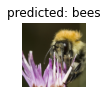

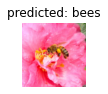

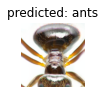

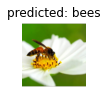

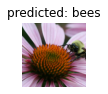

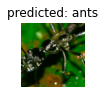

In [ ]:
visualize_model(model_conv_3_3)

plt.ioff()
plt.show()



---


# Conclusion Section:


---


# Note:
##( All the values are for the current run, if the code is run again it might change its results )
###1. In the comparison table, "initial" means the model parameter used in the code copied from the tutorial blog.
###2. By "Accuracy" I mean Validation accuracy.
###3. The "Validation loss" value is an observed approximate and is used just as a tool for qualitative comparison.
###3. By convergence I mean that as the epochs increase if the value is tending to an approximate value, that is by eye so actual may vary. I am considerinf a dying oscillation as a converging case as well. if there is no such convergence then I say it to be d.n.c. as in does not converge. If I mention oscillating with a value then that means that the curve is oscillating about a value, also observational may vary for another observer. 
###4. For convergence, I observationally chose the epoch number after which the cuves (loss and accuracy) kind of had smaller variations in comparison to the rest of the plot as the epoch of beginning of convergence.
---
---
#**For fine-tuned feature extractor CNN.**

1. Variation of training epochs.


| Training epochs | (approx) Converging value of Validation Loss | Convergence in (epochs) | Best Accuracy | (approx) Converging value of Accuracy | Convergence in (epochs) | Execution Time |
|---|---|---|---|---|---|---|
|30|0.2|7|0.954248|0.94|8|36m 11s|
|25 (initial)|0.2|5|0.954248|0.95|7|30m 30s|
|20|In range 0.24 - 0.21 (d.n.c.)|-|0.954248|Oscillating in 0.915 - 0.955|-|23m 38s|
|15|0.22 (oscillating)|-|0.954248|0.948|8|17m 47s|

**Conclusion:** There is not too much affected in terms of validation error and best accuracy. Although there is some differences at the converging value of accuracy, but that too is close. Mainly training times are affected. 

2. Variation of learning rate.


| Learning rate | (approx) Converging value of Validation Loss | Convergence in (epochs) | Best Accuracy | (approx) Converging value of Accuracy | Convergence in (epochs) | Execution Time |
|---|---|---|---|---|---|---|
|0.0001|0.22 (slight oscillation)|6|0.928105|0.92|6|30m 21s|
|0.001 (initial)|0.2|5|0.954248|0.95|7|30m 30s|
|0.005|0.6|6|0.771242|0.75|13|30m 20s|
|0.01|1.0|7|0.601307|0.55|13|30m 34s|

**Conclusion:** Accuracy is mostly affected by the changes in learning rate. The learning rate of 0.001 seem to be optimum or close to it since increasing or decreasing from that value decreases the performance (accuracy and loss parameters)

3. Variation of momentum.


| Momentum | (approx) Converging value of Validation Loss | Convergence in (epochs) | Best Accuracy | (approx) Converging value of Accuracy | Convergence in (epochs) | Execution Time |
|---|---|---|---|---|---|---|
|0.3|0.18|5|0.941176|0.935|3|30m 25s|
|0.6|0.15|8|0.967320|0.955|6|30m 26s|
|0.9 (initial)|0.2|5|0.954248|0.95|7|30m 30s|
|0.99|2.0|6|0.718954|0.55|8|30m 21s|

**Conclusion:** Here as well the momentum seems to affect the accuracy and validation loss. The optimum seems to be about or at 0.6 since increasing or decreasing from 0.6 shows increase of loss and decrease of accuracy.

---

---

# **For Fixed feature extractor CNN**


1. Variation of training epochs.


| Training epochs | (approx) Converging value of Validation Loss | Convergence in (epochs) | Best Accuracy | (approx) Converging value of Accuracy | Convergence in (epochs) | Execution Time |
|---|---|---|---|---|---|---|
|30|0.21|6|0.947712|Oscillates between 0.93 - 0.94|5|17m 32s|
|25 (initial)|0.19|7|0.954248|0.95|8|14m 27s|
|20|0.16|2|0.960784|0.95|2|11m 34s|
|15|0.2 (oscillatory)|7|0.954248|0.92|3|8m 42s|

**Conclusion:** Although a better accuracy, lesser validation error is seen for lesser training epochs (20 epochs), but decreaseing it further to 15 epochs makes it less favourable than the initial model.

2. Variation of learning rate.


| Learning rate | (approx) Converging value of Validation Loss | Convergence in (epochs) | Best Accuracy | (approx) Converging value of Accuracy | Convergence in (epochs) | Execution Time |
|---|---|---|---|---|---|---|
|0.0001|0.25|6|0.934641|0.93|3|14m 40s|
|0.001 (initial)|0.19|7|0.954248|0.95|8|14m 27s|
|0.005|0.5|3|0.947712|0.93|3|14m 40s|
|0.01|(oscillating)|-|0.954248|0.94|2|14m 45s|

**Conclusion:** The initial model has the better results among all the others, as decreasing or increasing it from 0.001 shows drops in perfromance. Although it has a decent convergence time its still predictable in terms of performance.

3. Variation of momentum.


| Momentum | (approx) Converging value of Validation Loss | Convergence in (epochs) | Best Accuracy | (approx) Converging value of Accuracy | Convergence in (epochs) | Execution Time |
|---|---|---|---|---|---|---|
|0.3|0.21|6|0.954248|0.945|6|14m 41s|
|0.6|0.19|2|0.954248|0.945|2|14m 45s|
|0.9 (initial)|0.19|7|0.954248|0.95|8|14m 27s|
|0.99|0.595|9|0.954248|0.93|10|14m 58s|

**Conclusion:** There is not much affected by momentum w.r.t. to best accuracy and a little interms of convergening accuracy, the momentum of 0.6 and 0.9 perform almost the same, but 0.6 converges faster. Also ther might be a better value in between 0.6 - 0.9, that is optimum.


---




---


---


# Task 1(e).


---



---



#  Introducing weight decay of 0.001, 0.01, 0.05, 0.1, 0.5
(Initially there was no decay present at all.)

Learned how to implement weight decay from : https://discuss.pytorch.org/t/how-does-sgd-weight-decay-work/33105

## Case 1 : decay = 0.001

Fine tuned Feature Extractor type CNN

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6987 Acc: 0.6762
val Loss: 0.6825 Acc: 0.7647

Epoch 1/24
----------
train Loss: 0.5202 Acc: 0.7582
val Loss: 0.3193 Acc: 0.8758

Epoch 2/24
----------
train Loss: 0.5057 Acc: 0.7992
val Loss: 0.2896 Acc: 0.9020

Epoch 3/24
----------
train Loss: 0.4742 Acc: 0.8156
val Loss: 0.3770 Acc: 0.8824

Epoch 4/24
----------
train Loss: 0.5438 Acc: 0.7746
val Loss: 0.3453 Acc: 0.8627

Epoch 5/24
----------
train Loss: 0.3885 Acc: 0.8279
val Loss: 0.2756 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.8090 Acc: 0.7377
val Loss: 0.3954 Acc: 0.8627

Epoch 7/24
----------
train Loss: 0.5472 Acc: 0.7951
val Loss: 0.2957 Acc: 0.8889

Epoch 8/24
----------
train Loss: 0.3188 Acc: 0.8770
val Loss: 0.2214 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3195 Acc: 0.8689
val Loss: 0.2091 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.2168 Acc: 0.8975
val Loss: 0.1920 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.3206 Acc: 0.8443
val Loss: 0.2127 Acc: 0.9150

Epoch 12/24
----------
t

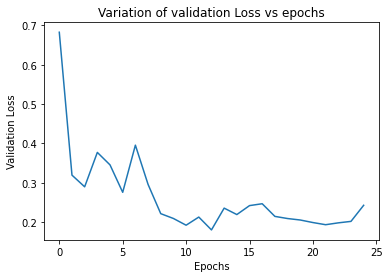

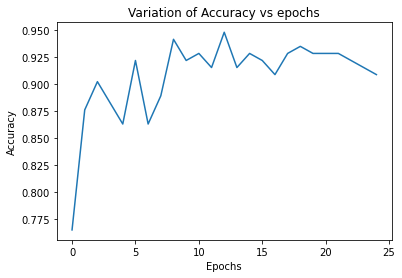

In [ ]:
model_ft_dec_1_1 = models.resnet18(pretrained=True)
num_ftrs = model_ft_dec_1_1.fc.in_features
# Here the size of each output sample is set to 2.
model_ft_dec_1_1.fc = nn.Linear(num_ftrs, 2)

model_ft_dec_1_1 = model_ft_dec_1_1.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft_dec_1_1 = optim.SGD(model_ft_dec_1_1.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft_dec_1_1, step_size=7, gamma=0.1)

model_ft_dec_1_1 = train_model(model_ft_dec_1_1, criterion, optimizer_ft_dec_1_1, exp_lr_scheduler, num_epochs=25)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


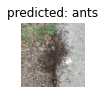

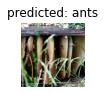

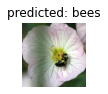

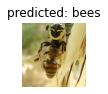

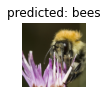

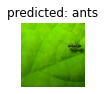

In [ ]:
visualize_model(model_ft_dec_1_1)

plt.ioff()
plt.show()

Fixed Feature Extractor type CNN

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.7257 Acc: 0.6066
val Loss: 0.3441 Acc: 0.8693

Epoch 1/24
----------
train Loss: 0.4472 Acc: 0.7746
val Loss: 0.4439 Acc: 0.7974

Epoch 2/24
----------
train Loss: 0.4079 Acc: 0.8033
val Loss: 0.2127 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.4780 Acc: 0.7869
val Loss: 0.2155 Acc: 0.9150

Epoch 4/24
----------
train Loss: 0.4063 Acc: 0.8443
val Loss: 0.1679 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.5743 Acc: 0.7541
val Loss: 0.1670 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.5257 Acc: 0.7951
val Loss: 0.2673 Acc: 0.8954

Epoch 7/24
----------
train Loss: 0.4141 Acc: 0.8115
val Loss: 0.1803 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3480 Acc: 0.8566
val Loss: 0.2250 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.2827 Acc: 0.8689
val Loss: 0.1823 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3571 Acc: 0.8566
val Loss: 0.2294 Acc: 0.9150

Epoch 11/24
----------
train Loss: 0.3455 Acc: 0.8484
val Loss: 0.1859 Acc: 0.9412

Epoch 12/24
----------
t

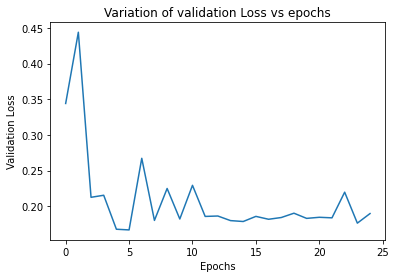

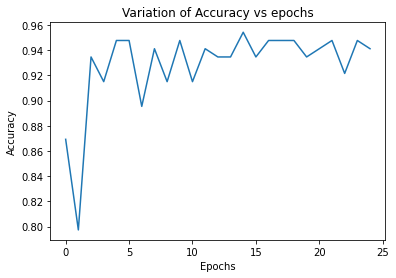

In [ ]:
model_conv_dec_2_1 = torchvision.models.resnet18(pretrained=True)
for param in model_conv_dec_2_1.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv_dec_2_1.fc.in_features
model_conv_dec_2_1.fc = nn.Linear(num_ftrs, 2)

model_conv_dec_2_1 = model_conv_dec_2_1.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv_dec_2_1 = optim.SGD(model_conv_dec_2_1.fc.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv_dec_2_1, step_size=7, gamma=0.1)

model_conv_dec_2_1 = train_model(model_conv_dec_2_1, criterion, optimizer_conv_dec_2_1, exp_lr_scheduler, num_epochs=25)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


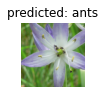

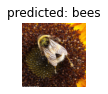

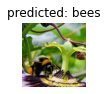

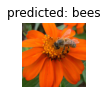

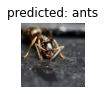

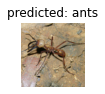

In [ ]:
visualize_model(model_conv_dec_2_1)

plt.ioff()
plt.show()

## Case 2 : decay = 0.01

Fine tuned Feature Extractor type CNN

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.7240 Acc: 0.6393
val Loss: 0.4457 Acc: 0.7974

Epoch 1/24
----------
train Loss: 0.4649 Acc: 0.7828
val Loss: 0.3843 Acc: 0.8497

Epoch 2/24
----------
train Loss: 0.4221 Acc: 0.8402
val Loss: 0.1741 Acc: 0.9542

Epoch 3/24
----------
train Loss: 0.4508 Acc: 0.8115
val Loss: 0.2510 Acc: 0.9020

Epoch 4/24
----------
train Loss: 0.4458 Acc: 0.8279
val Loss: 0.4262 Acc: 0.8562

Epoch 5/24
----------
train Loss: 0.6193 Acc: 0.7828
val Loss: 0.3130 Acc: 0.8824

Epoch 6/24
----------
train Loss: 0.5471 Acc: 0.7746
val Loss: 0.5806 Acc: 0.8105

Epoch 7/24
----------
train Loss: 0.4637 Acc: 0.8033
val Loss: 0.2268 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.3391 Acc: 0.8566
val Loss: 0.2177 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.3545 Acc: 0.8607
val Loss: 0.2122 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.3511 Acc: 0.8443
val Loss: 0.2110 Acc: 0.9085

Epoch 11/24
----------
train Loss: 0.2662 Acc: 0.8730
val Loss: 0.2106 Acc: 0.9150

Epoch 12/24
----------
t

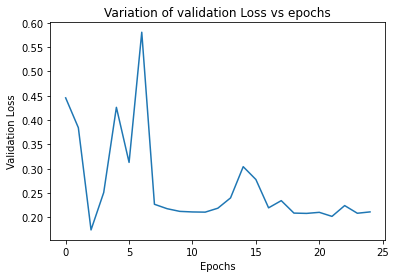

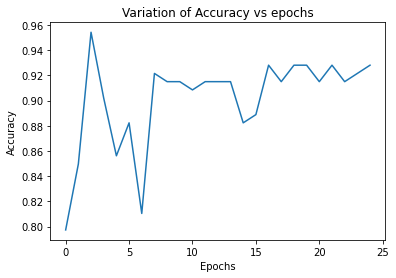

In [ ]:
model_ft_dec_1_2 = models.resnet18(pretrained=True)
num_ftrs = model_ft_dec_1_2.fc.in_features
# Here the size of each output sample is set to 2.
model_ft_dec_1_2.fc = nn.Linear(num_ftrs, 2)

model_ft_dec_1_2 = model_ft_dec_1_2.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft_dec_1_2 = optim.SGD(model_ft_dec_1_2.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft_dec_1_2, step_size=7, gamma=0.1)

model_ft_dec_1_2 = train_model(model_ft_dec_1_2, criterion, optimizer_ft_dec_1_2, exp_lr_scheduler, num_epochs=25)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


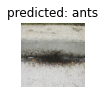

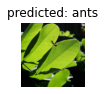

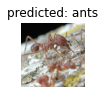

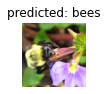

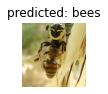

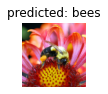

In [ ]:
visualize_model(model_ft_dec_1_2)

plt.ioff()
plt.show()

Fixed Feature Extractor type CNN

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.5839 Acc: 0.6885
val Loss: 0.4934 Acc: 0.7451

Epoch 1/24
----------
train Loss: 0.5983 Acc: 0.7213
val Loss: 0.1643 Acc: 0.9477

Epoch 2/24
----------
train Loss: 0.5632 Acc: 0.7500
val Loss: 0.2222 Acc: 0.9216

Epoch 3/24
----------
train Loss: 0.5283 Acc: 0.7623
val Loss: 0.1805 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.6028 Acc: 0.7664
val Loss: 0.2019 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.5172 Acc: 0.7787
val Loss: 0.1983 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.4104 Acc: 0.8033
val Loss: 0.1894 Acc: 0.9346

Epoch 7/24
----------
train Loss: 0.3395 Acc: 0.8443
val Loss: 0.1855 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3080 Acc: 0.8566
val Loss: 0.2120 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.4214 Acc: 0.8074
val Loss: 0.1833 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3118 Acc: 0.8689
val Loss: 0.1838 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.3056 Acc: 0.8525
val Loss: 0.1788 Acc: 0.9346

Epoch 12/24
----------
t

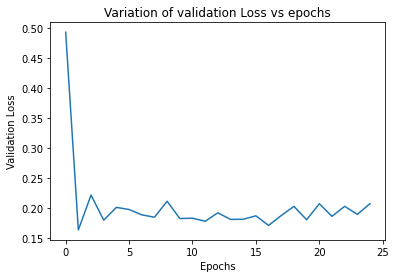

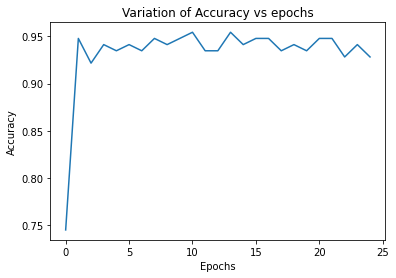

In [ ]:
model_conv_dec_2_2 = torchvision.models.resnet18(pretrained=True)
for param in model_conv_dec_2_2.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv_dec_2_2.fc.in_features
model_conv_dec_2_2.fc = nn.Linear(num_ftrs, 2)

model_conv_dec_2_2 = model_conv_dec_2_2.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv_dec_2_2 = optim.SGD(model_conv_dec_2_2.fc.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv_dec_2_2, step_size=7, gamma=0.1)

model_conv_dec_2_2 = train_model(model_conv_dec_2_2, criterion, optimizer_conv_dec_2_2, exp_lr_scheduler, num_epochs=25)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


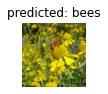

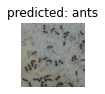

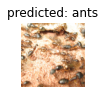

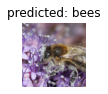

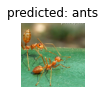

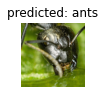

In [ ]:
visualize_model(model_conv_dec_2_2)

plt.ioff()
plt.show()

## Case 3 : decay = 0.05

Fine tuned Feature Extractor type CNN

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6249 Acc: 0.7131
val Loss: 0.2785 Acc: 0.9346

Epoch 1/24
----------
train Loss: 0.6501 Acc: 0.7664
val Loss: 0.8278 Acc: 0.6928

Epoch 2/24
----------
train Loss: 0.5095 Acc: 0.7746
val Loss: 0.2968 Acc: 0.8824

Epoch 3/24
----------
train Loss: 0.4910 Acc: 0.8156
val Loss: 0.4669 Acc: 0.8366

Epoch 4/24
----------
train Loss: 0.5068 Acc: 0.7664
val Loss: 0.3005 Acc: 0.8627

Epoch 5/24
----------
train Loss: 0.5001 Acc: 0.7705
val Loss: 0.2891 Acc: 0.8758

Epoch 6/24
----------
train Loss: 0.4219 Acc: 0.8115
val Loss: 0.4179 Acc: 0.8366

Epoch 7/24
----------
train Loss: 0.3785 Acc: 0.8402
val Loss: 0.2792 Acc: 0.8889

Epoch 8/24
----------
train Loss: 0.2855 Acc: 0.8811
val Loss: 0.2254 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.3095 Acc: 0.8852
val Loss: 0.2292 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.3117 Acc: 0.8566
val Loss: 0.2211 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.3045 Acc: 0.8893
val Loss: 0.2305 Acc: 0.9216

Epoch 12/24
----------
t

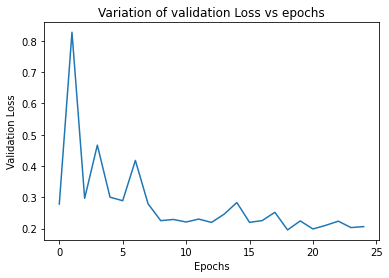

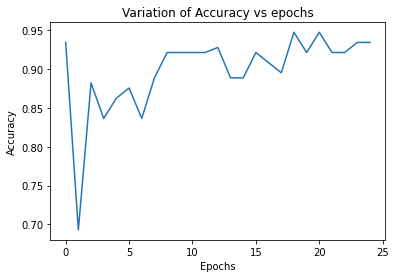

In [ ]:
model_ft_dec_1_3 = models.resnet18(pretrained=True)
num_ftrs = model_ft_dec_1_3.fc.in_features
# Here the size of each output sample is set to 2.
model_ft_dec_1_3.fc = nn.Linear(num_ftrs, 2)

model_ft_dec_1_3 = model_ft_dec_1_3.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft_dec_1_3 = optim.SGD(model_ft_dec_1_3.parameters(), lr=0.001, momentum=0.9, weight_decay=0.05)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft_dec_1_3, step_size=7, gamma=0.1)

model_ft_dec_1_3 = train_model(model_ft_dec_1_3, criterion, optimizer_ft_dec_1_3, exp_lr_scheduler, num_epochs=25)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


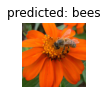

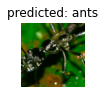

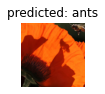

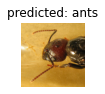

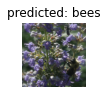

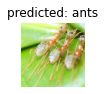

In [ ]:
visualize_model(model_ft_dec_1_3)

plt.ioff()
plt.show()

Fixed Feature Extractor type CNN

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.7514 Acc: 0.6025
val Loss: 0.3333 Acc: 0.8366

Epoch 1/24
----------
train Loss: 0.6265 Acc: 0.7377
val Loss: 0.3350 Acc: 0.8366

Epoch 2/24
----------
train Loss: 0.5916 Acc: 0.7623
val Loss: 0.1837 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.3783 Acc: 0.8033
val Loss: 0.1581 Acc: 0.9673

Epoch 4/24
----------
train Loss: 0.4362 Acc: 0.8074
val Loss: 0.2049 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.5333 Acc: 0.7746
val Loss: 0.1690 Acc: 0.9542

Epoch 6/24
----------
train Loss: 0.5656 Acc: 0.7664
val Loss: 0.3359 Acc: 0.8693

Epoch 7/24
----------
train Loss: 0.3022 Acc: 0.8730
val Loss: 0.2063 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3081 Acc: 0.8607
val Loss: 0.1708 Acc: 0.9608

Epoch 9/24
----------
train Loss: 0.3204 Acc: 0.8607
val Loss: 0.2188 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.3441 Acc: 0.8443
val Loss: 0.1916 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3364 Acc: 0.8361
val Loss: 0.1847 Acc: 0.9477

Epoch 12/24
----------
t

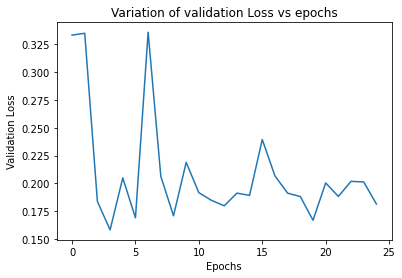

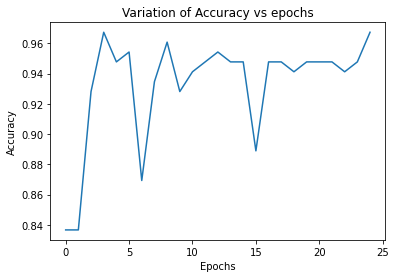

In [ ]:
model_conv_dec_2_3 = torchvision.models.resnet18(pretrained=True)
for param in model_conv_dec_2_3.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv_dec_2_3.fc.in_features
model_conv_dec_2_3.fc = nn.Linear(num_ftrs, 2)

model_conv_dec_2_3 = model_conv_dec_2_3.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv_dec_2_3 = optim.SGD(model_conv_dec_2_3.fc.parameters(), lr=0.001, momentum=0.9, weight_decay=0.05)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv_dec_2_3, step_size=7, gamma=0.1)

model_conv_dec_2_3 = train_model(model_conv_dec_2_3, criterion, optimizer_conv_dec_2_3, exp_lr_scheduler, num_epochs=25)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


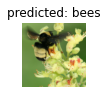

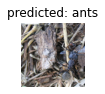

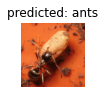

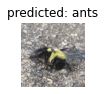

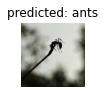

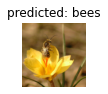

In [ ]:
visualize_model(model_conv_dec_2_3)

plt.ioff()
plt.show()

## Case 4 : decay = 0.1

Fine tuned Feature Extractor type CNN

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6002 Acc: 0.6885
val Loss: 0.3013 Acc: 0.8824

Epoch 1/24
----------
train Loss: 0.5606 Acc: 0.7787
val Loss: 0.2763 Acc: 0.9085

Epoch 2/24
----------
train Loss: 0.4471 Acc: 0.8115
val Loss: 0.2660 Acc: 0.8889

Epoch 3/24
----------
train Loss: 0.4714 Acc: 0.8197
val Loss: 0.2134 Acc: 0.9150

Epoch 4/24
----------
train Loss: 0.3634 Acc: 0.8484
val Loss: 0.2780 Acc: 0.8889

Epoch 5/24
----------
train Loss: 0.4030 Acc: 0.8156
val Loss: 0.4369 Acc: 0.8170

Epoch 6/24
----------
train Loss: 0.4346 Acc: 0.7787
val Loss: 0.2702 Acc: 0.9085

Epoch 7/24
----------
train Loss: 0.3824 Acc: 0.8238
val Loss: 0.2520 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.2950 Acc: 0.8770
val Loss: 0.2460 Acc: 0.8824

Epoch 9/24
----------
train Loss: 0.2906 Acc: 0.8689
val Loss: 0.2453 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.3158 Acc: 0.8484
val Loss: 0.2447 Acc: 0.9085

Epoch 11/24
----------
train Loss: 0.3219 Acc: 0.8566
val Loss: 0.2129 Acc: 0.9216

Epoch 12/24
----------
t

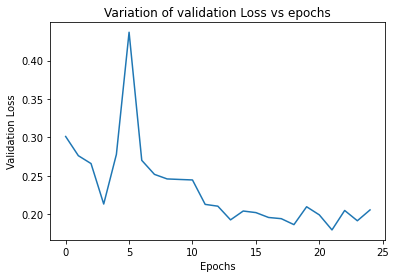

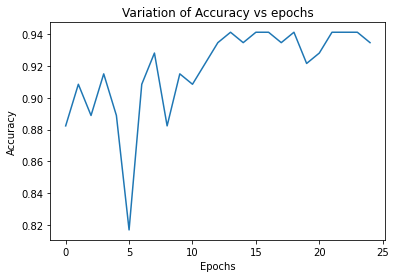

In [ ]:
model_ft_dec_1_4 = models.resnet18(pretrained=True)
num_ftrs = model_ft_dec_1_4.fc.in_features
# Here the size of each output sample is set to 2.
model_ft_dec_1_4.fc = nn.Linear(num_ftrs, 2)

model_ft_dec_1_4 = model_ft_dec_1_4.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft_dec_1_4 = optim.SGD(model_ft_dec_1_4.parameters(), lr=0.001, momentum=0.9, weight_decay=0.1)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft_dec_1_4, step_size=7, gamma=0.1)

model_ft_dec_1_4 = train_model(model_ft_dec_1_4, criterion, optimizer_ft_dec_1_4, exp_lr_scheduler, num_epochs=25)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


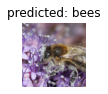

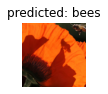

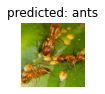

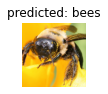

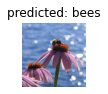

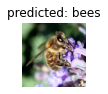

In [ ]:
visualize_model(model_ft_dec_1_4)

plt.ioff()
plt.show()

Fixed Feature Extractor type CNN

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.7022 Acc: 0.6230
val Loss: 0.2472 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.4050 Acc: 0.8074
val Loss: 0.2002 Acc: 0.9412

Epoch 2/24
----------
train Loss: 0.4657 Acc: 0.7910
val Loss: 0.2179 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.5511 Acc: 0.7336
val Loss: 0.2942 Acc: 0.9085

Epoch 4/24
----------
train Loss: 0.4659 Acc: 0.7787
val Loss: 0.2604 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.5100 Acc: 0.7664
val Loss: 0.2372 Acc: 0.9281

Epoch 6/24
----------
train Loss: 0.4179 Acc: 0.8156
val Loss: 0.3196 Acc: 0.8693

Epoch 7/24
----------
train Loss: 0.3333 Acc: 0.8484
val Loss: 0.2042 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3005 Acc: 0.8607
val Loss: 0.2042 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3331 Acc: 0.8484
val Loss: 0.1887 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.3413 Acc: 0.8443
val Loss: 0.1969 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3564 Acc: 0.8238
val Loss: 0.2181 Acc: 0.9412

Epoch 12/24
----------
t

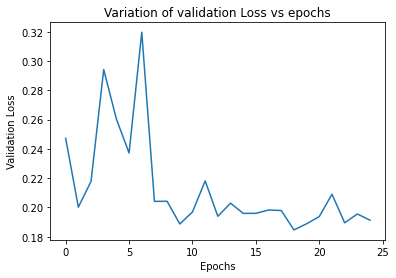

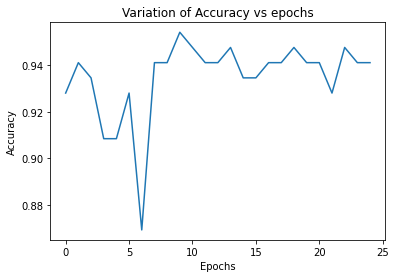

In [ ]:
model_conv_dec_2_4 = torchvision.models.resnet18(pretrained=True)
for param in model_conv_dec_2_4.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv_dec_2_4.fc.in_features
model_conv_dec_2_4.fc = nn.Linear(num_ftrs, 2)

model_conv_dec_2_4 = model_conv_dec_2_4.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv_dec_2_4 = optim.SGD(model_conv_dec_2_4.fc.parameters(), lr=0.001, momentum=0.9, weight_decay=0.1)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv_dec_2_4, step_size=7, gamma=0.1)

model_conv_dec_2_4 = train_model(model_conv_dec_2_4, criterion, optimizer_conv_dec_2_4, exp_lr_scheduler, num_epochs=25)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


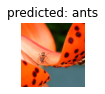

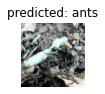

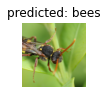

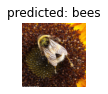

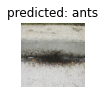

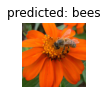

In [ ]:
visualize_model(model_conv_dec_2_4)

plt.ioff()
plt.show()

## Case 5 : decay = 0.5

Fine tuned Feature Extractor type CNN

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6344 Acc: 0.6639
val Loss: 0.2984 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.4702 Acc: 0.7787
val Loss: 0.3342 Acc: 0.8497

Epoch 2/24
----------
train Loss: 0.4537 Acc: 0.7828
val Loss: 0.4303 Acc: 0.8954

Epoch 3/24
----------
train Loss: 0.4284 Acc: 0.7951
val Loss: 0.5117 Acc: 0.7712

Epoch 4/24
----------
train Loss: 0.6050 Acc: 0.6680
val Loss: 0.6537 Acc: 0.6601

Epoch 5/24
----------
train Loss: 0.5903 Acc: 0.7090
val Loss: 0.6466 Acc: 0.6863

Epoch 6/24
----------
train Loss: 0.6532 Acc: 0.5943
val Loss: 0.6817 Acc: 0.5882

Epoch 7/24
----------
train Loss: 0.6466 Acc: 0.6598
val Loss: 0.6300 Acc: 0.7124

Epoch 8/24
----------
train Loss: 0.6369 Acc: 0.6844
val Loss: 0.6389 Acc: 0.7516

Epoch 9/24
----------
train Loss: 0.6510 Acc: 0.6352
val Loss: 0.6519 Acc: 0.7451

Epoch 10/24
----------
train Loss: 0.6384 Acc: 0.6803
val Loss: 0.6464 Acc: 0.6928

Epoch 11/24
----------
train Loss: 0.6521 Acc: 0.6680
val Loss: 0.6330 Acc: 0.7386

Epoch 12/24
----------
t

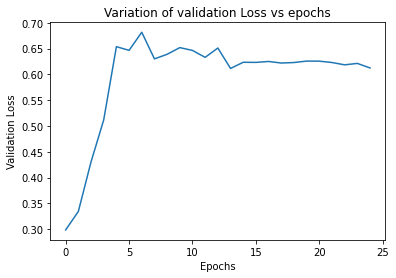

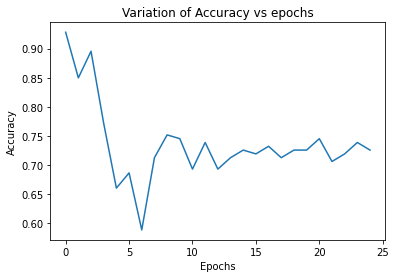

In [ ]:
model_ft_dec_1_5 = models.resnet18(pretrained=True)
num_ftrs = model_ft_dec_1_5.fc.in_features
# Here the size of each output sample is set to 2.
model_ft_dec_1_5.fc = nn.Linear(num_ftrs, 2)

model_ft_dec_1_5 = model_ft_dec_1_5.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft_dec_1_5 = optim.SGD(model_ft_dec_1_5.parameters(), lr=0.001, momentum=0.9, weight_decay=0.5)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft_dec_1_5, step_size=7, gamma=0.1)

model_ft_dec_1_5 = train_model(model_ft_dec_1_5, criterion, optimizer_ft_dec_1_5, exp_lr_scheduler, num_epochs=25)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


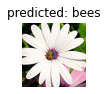

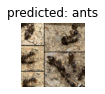

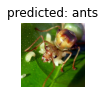

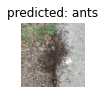

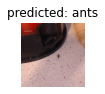

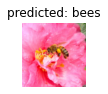

In [ ]:
visualize_model(model_ft_dec_1_5)

plt.ioff()
plt.show()

Fixed Feature Extractor type CNN

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6533 Acc: 0.6598
val Loss: 0.3165 Acc: 0.8693

Epoch 1/24
----------
train Loss: 0.5219 Acc: 0.7500
val Loss: 0.2539 Acc: 0.9085

Epoch 2/24
----------
train Loss: 0.5006 Acc: 0.7090
val Loss: 0.2335 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.5262 Acc: 0.7623
val Loss: 0.2268 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.5152 Acc: 0.7459
val Loss: 0.5183 Acc: 0.7778

Epoch 5/24
----------
train Loss: 0.5208 Acc: 0.7541
val Loss: 0.1949 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.4344 Acc: 0.7869
val Loss: 0.3382 Acc: 0.8693

Epoch 7/24
----------
train Loss: 0.3722 Acc: 0.8320
val Loss: 0.2183 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.4047 Acc: 0.8361
val Loss: 0.2108 Acc: 0.9542

Epoch 9/24
----------
train Loss: 0.3918 Acc: 0.8443
val Loss: 0.2247 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3544 Acc: 0.8484
val Loss: 0.2096 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.4035 Acc: 0.8033
val Loss: 0.2057 Acc: 0.9608

Epoch 12/24
----------
t

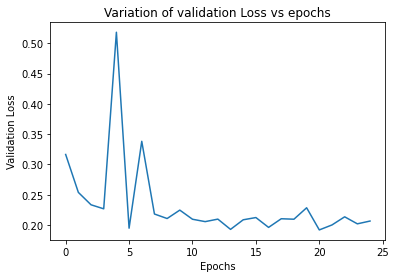

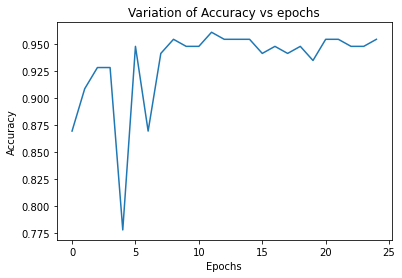

In [ ]:
model_conv_dec_2_5 = torchvision.models.resnet18(pretrained=True)
for param in model_conv_dec_2_5.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv_dec_2_5.fc.in_features
model_conv_dec_2_5.fc = nn.Linear(num_ftrs, 2)

model_conv_dec_2_5 = model_conv_dec_2_5.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv_dec_2_5 = optim.SGD(model_conv_dec_2_5.fc.parameters(), lr=0.001, momentum=0.9, weight_decay=0.5)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv_dec_2_5, step_size=7, gamma=0.1)

model_conv_dec_2_5 = train_model(model_conv_dec_2_5, criterion, optimizer_conv_dec_2_5, exp_lr_scheduler, num_epochs=25)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


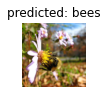

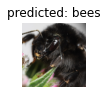

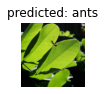

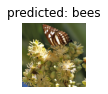

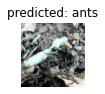

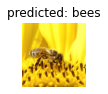

In [ ]:
visualize_model(model_conv_dec_2_5)

plt.ioff()
plt.show()

# Conclusion:
---
For Fine tuned feature extractor type CNN


| Weight Decay | (approx) Converging value of Validation Loss | Convergence in (epochs) | Best Accuracy | (approx) Converging value of Accuracy | Convergence in (epochs) | Execution Time |
|---|---|---|---|---|---|---|
|0.001|0.2|8|0.947712|0.925|8|31m 20s|
|0.01|0.2|7|0.954248|0.92|7|31m 15s|
|0.05|0.2|8|0.947712|0.93|8|31m 10s|
|0.1|0.2|11|0.941176|0.93|12|31m 06s|
|0.5|0.62|4|0.928105|0.72|7|31m 19s|

---

For Fixed feature extractor type CNN


| Weight Decay | (approx) Converging value of Validation Loss | Convergence in (epochs) | Best Accuracy | (approx) Converging value of Accuracy | Convergence in (epochs) | Execution Time |
|---|---|---|---|---|---|---|
|0.001|0.18|2|0.954248|0.94|2|14m 50s|
|0.01|0.18|1|0.954248|0.94|1|14m 45s|
|0.05|0.18|7|0.967320|Oscillates between 0.9 - 0.96|-|14m 49s|
|0.1|0.19|7|0.954248|0.94|7|14m 54s|
|0.5|0.2|7|0.960784|0.95|7|14m 54s|

---

# Conclusion : The best value among these values of decay chosen is 0.01 since its seen that the net validation error is the least and the converging value of accuracy is good considering all the other values which are very close for both fine tuned feature extractor type CNN and fixed feature extractor type CNN.
